In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange
from math import floor

%load_ext autoreload
%autoreload 2

from utils import *
from rd_transformer import *
from tokenizer_bpe import *

In [2]:
path = 'F:/$Daten/datasets/DLK-master/'
df_train = pd.read_csv(path + 'dlk_train.csv').fillna('')
df_val = pd.read_csv(path + 'dlk_val.csv').fillna('')
df_train

,Pub year,Author,Title,Text,Encoded
0,1747,"Ebeling, Johann Justus",Der Sommer.,Angenehme Sommerszeiten! euer\nfeuerreicher St...,"['An', 'gen', 'eh', 'me', '</w>', 'Somm', 'ers..."
1,1747,"Ebeling, Johann Justus",Die mannigfaltige \n Weisheit GOttes \n im ...,"Ich will nunmehr weiter singen,\nVon den wunde...","['Ich', '</w>', 'will', '</w>', 'n', 'un', 'me..."
2,1747,"Ebeling, Johann Justus",Die \n angenehme Morgenröthe \n Und \n da...,Der Morgenröthe schimmernd Pran-\ngen\nVerkünd...,"['Der', '</w>', 'Morgen', 'rö', 'the', '</w>',..."
3,1747,"Ebeling, Johann Justus",Anrede an den herrlichen GOtt \n um Abwendung...,"Herrlich bist du, grosser GOtt! in\ndem Himmel...","['Herr', 'lich', '</w>', 'bist', '</w>', 'du',..."
4,1747,"Ebeling, Johann Justus",Die \n heilige Garten-Schule \n der lehrend...,"Jhr Menschen! die ihr euch entfernet,\nVon all...","['Jhr', '</w>', 'Mensch', 'en', '!', '</w>', '..."
...,...,...,...,...,...
59174,1773,"Herder, Johann Gottfried",25. Wilhelms Geist,"Da kam ein Geist zu Gretchens Thür,\nMit manch...","['Da', '</w>', 'kam', '</w>', 'ein', '</w>', '..."
59175,1773,"Herder, Johann Gottfried",27. Der Brauttanz,"Tanz, der du Gesetze\nUnsern Füßen giebst,\nHa...","['Tan', 'z', ',', '</w>', 'der', '</w>', 'du',..."
59176,1773,"Herder, Johann Gottfried",28. Lied vom Hofe,"Wer sich nimmt an,\nUnd 's Rädlein kan\nHübsch...","['Wer', '</w>', 'sich', '</w>', 'nimmt', '</w>..."
59177,1773,"Herder, Johann Gottfried",29. Frühlingslied,"Der Schnee zerschmilzt, der Frühling kommt\nMi...","['Der', '</w>', 'Schnee', '</w>', 'z', 'ersch'..."


In [3]:
tokenizer = Tokenizer()
tokenizer.t2i, tokenizer.i2t, tokenizer.bpe_code = torch.load('dlk_tokenizer.dat')
tokenizer.t2i = defaultdict(lambda: tokenizer.t2i['<U>'], tokenizer.t2i)
tokenizer.t2i['<U>'] = len(tokenizer.t2i)
tokenizer.i2t = { i: t for t, i in tokenizer.t2i.items() }
tokenizer.NTOK = len(tokenizer.t2i)+10

In [11]:
MAX_LEN = 180 # maximale Anzahl Tokens
YEAR_MIN = 1497
YEAR_MAX = 1923
NBINS = YEAR_MAX-YEAR_MIN+1

In [5]:
tokenizer.t2i
#tokenizer.tokenize('Hello great world!', ints=False)

defaultdict(<function __main__.<lambda>()>,
            {'warst': 0,
             'Wölk': 1,
             'Wohnung': 2,
             'Flöten': 3,
             'ἦ': 4,
             'tausendf': 5,
             'bleibt': 6,
             'bequ': 7,
             'stechen': 8,
             'Fuhr': 9,
             '8': 10,
             'nd': 11,
             'Gei': 12,
             'ellen': 13,
             '5': 14,
             'ῶ': 15,
             'rühmen': 16,
             'strenge': 17,
             'entro': 18,
             'wo': 19,
             'Murmeln': 20,
             'irdisch': 21,
             'bese': 22,
             'Christenth': 23,
             'Zornes': 24,
             'bunte': 25,
             'gessen': 26,
             'Weltm': 27,
             'wirds': 28,
             'sp': 29,
             'Will': 30,
             'ölf': 31,
             'Is': 32,
             'Jedi': 33,
             'Dör': 34,
             'Hauch': 35,
             'Schulter': 36,
             'verg

In [17]:
def encode(string, evl=True, rnd=True):
    'Tokenizes and encodes a string to a format suitable for the neural network'
    if evl: tokens = eval(string)
    else: tokens = string
    if len(tokens) > MAX_LEN+1 and rnd:
        i = np.random.randint(0, len(tokens)-MAX_LEN-1)
        tokens = tokens[i:i+MAX_LEN]
    tokens = ['<S>'] + tokens
    tokens = tokenizer.tokenize(tokens, encd=False)
    x = np.zeros(MAX_LEN+1, dtype=int)
    x[:] = tokenizer.t2i['</S>']
    for k, l in enumerate(tokens[:MAX_LEN+1]):
        x[k] = l
    x = x[:MAX_LEN+1]
    return x
    

def batchgen(bsize=64):
    N = len(df_train)
    ep = 0
    while True:
        inds = np.random.permutation(range(N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = np.zeros((bsize, MAX_LEN+1), dtype=int)
            zs = np.zeros((bsize))
            for i, j in enumerate(mb):
                x = df_train['Encoded'][j]
                z = df_train['Pub year'][j]
                xs[i] = encode(x)
                zs[i] = z - YEAR_MIN
            yield xs[:,:-1], zs
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1
    
bg = batchgen()
xs, zs = next(bg)
print(tokenizer.detokenize(list(xs[0])))
zs+YEAR_MIN

<S>Ach seht! da ligt das Kind von ädelem G.mühte/
Des Stammes schönster Zweig/ in einer Todtenbar/
Der seiner Eltern lust/ und höchste Hoffnung war/
Vom Tode hingemetzt in seiner schönsten Blühte.
Gott nimmt die Seeli weg; das Grab den Cörper hälte
Sein ädles Tugendlob bleibt aber in der Welt.

 </S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S>


array([1652., 1759., 1657., 1755., 1787., 1630., 1842., 1848., 1733.,
       1839., 1890., 1806., 1872., 1847., 1695., 1885., 1896., 1827.,
       1743., 1798., 1630., 1808., 1733., 1794., 1686., 1773., 1870.,
       1844., 1854., 1709., 1815., 1590., 1877., 1800., 1748., 1813.,
       1778., 1887., 1701., 1709., 1870., 1806., 1892., 1613., 1887.,
       1872., 1914., 1754., 1742., 1834., 1624., 1849., 1838., 1887.,
       1912., 1695., 1675., 1701., 1900., 1838., 1854., 1806., 1650.,
       1837.])

In [7]:
net = Net(n=256, nh=4, ntok=tokenizer.NTOK, nbins=NBINS)
net.optim = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))
net.iters = 0
net.losses = []
net.vlosses = []
bg = batchgen()

In [8]:
for m in net.modules():
    if type(m) == nn.Dropout:
        ##m.p = 0.5
        print('here')

here
here
here
here
here
here
here
here
here


In [9]:
#weights = torch.load('rd_weights_281123.dat')
#net.load_state_dict(weights, strict=False)

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


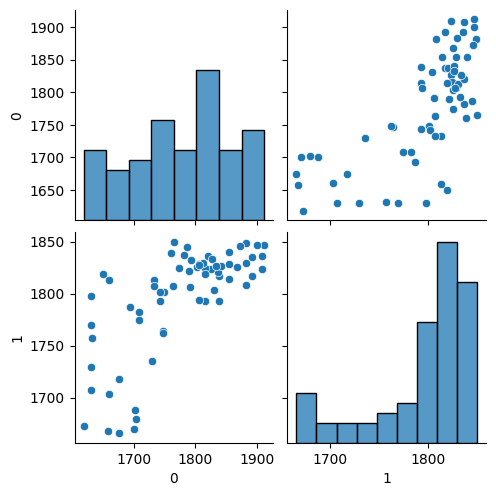

(tensor(4.0701, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.9675, device='cuda:0', grad_fn=<NllLossBackward0>))

In [18]:
def valloss(plot=False):
    net.eval()
    xs, zs = [], []
    for i in range(0, len(df_val), 100):
        x = df_val['Encoded'][i]
        z = df_val['Pub year'][i]
        x = encode(x)
        z = z - YEAR_MIN
        xs.append(x)
        zs.append(z)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    loss = F.nll_loss(torch.log_softmax(zp, dim=1), zs.long())
    if plot:
        zp = F.softmax(zp, dim=1)
        zp, zs = t2np(zp, zs)
        zp = np.sum(zp * np.arange(NBINS), -1)
        pairplot(zs+YEAR_MIN, zp+YEAR_MIN)
        plt.show()
    return loss

def Loss():
    net.train()
    xs, zs = next(bg)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    return F.nll_loss(torch.log_softmax(zp, dim=1), zs.long())

valloss(True), Loss()

  0%|          | 0/999999 [00:00<?, ?it/s]

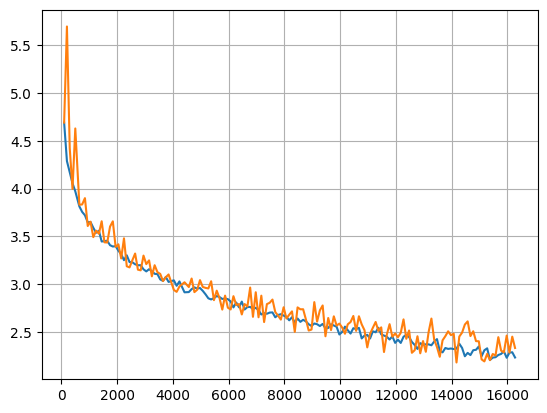

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


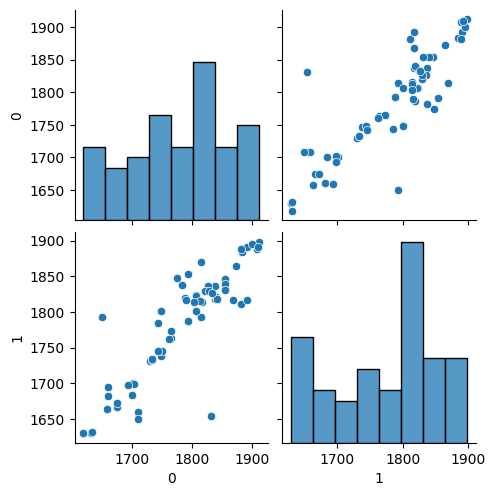

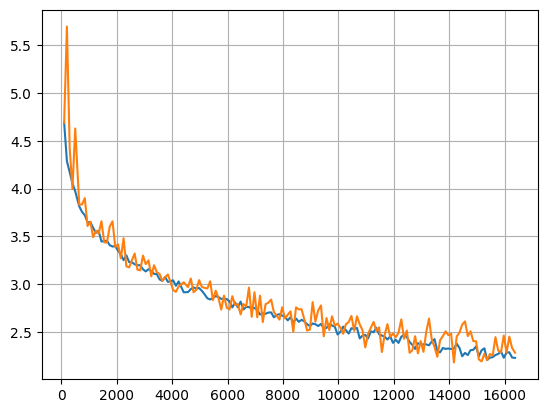

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


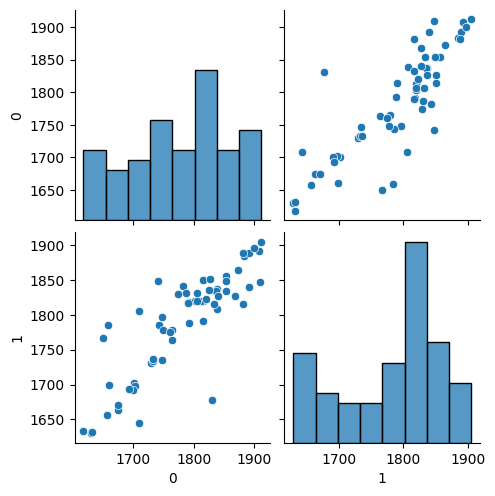

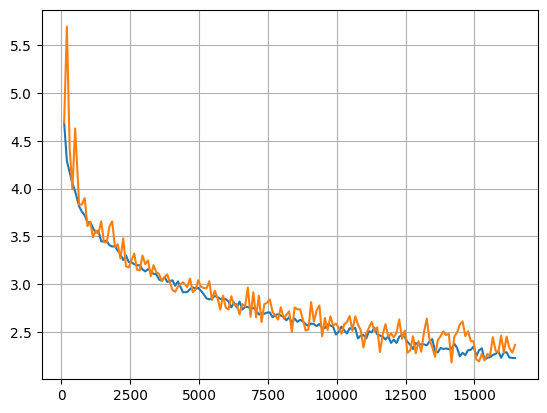

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


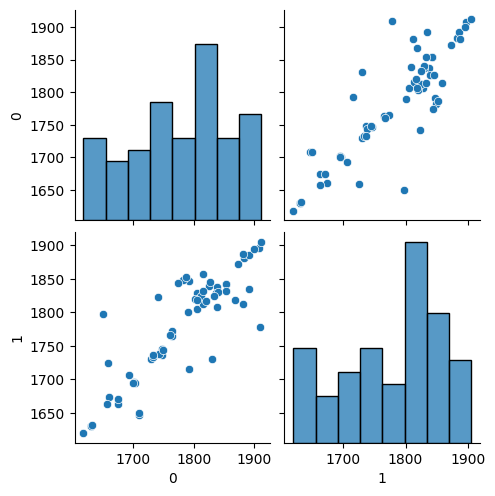

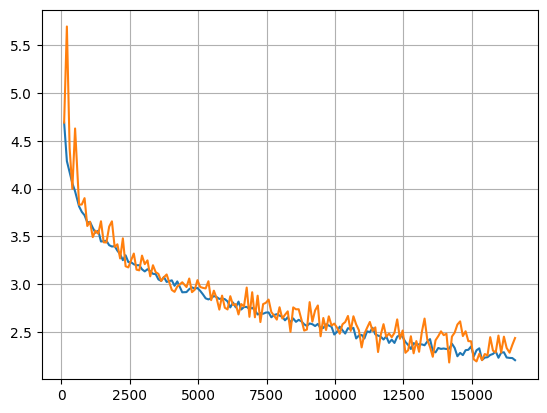

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


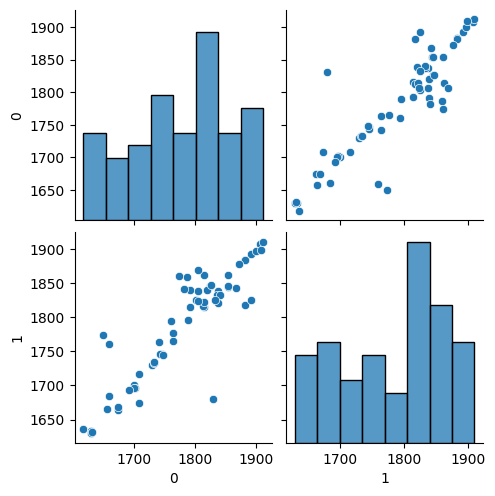

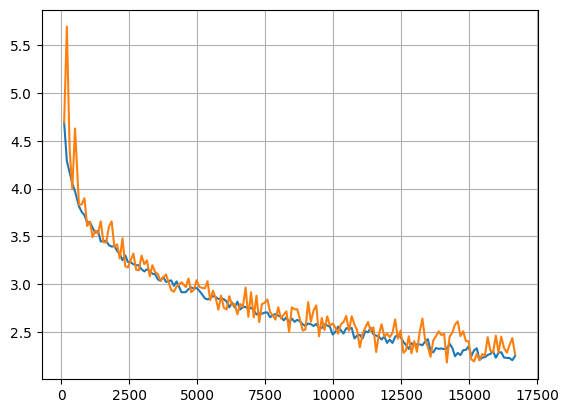

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


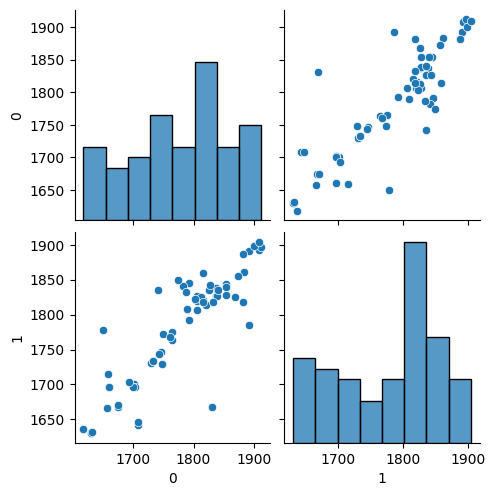

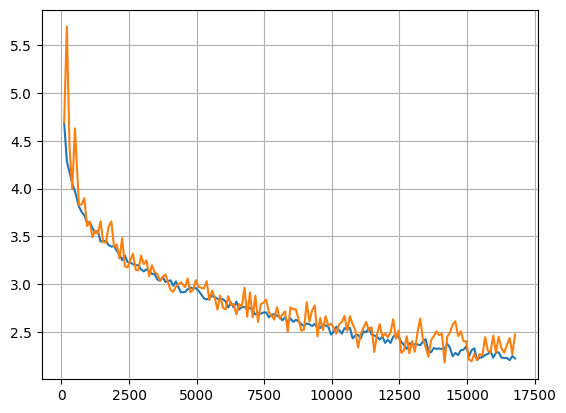

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


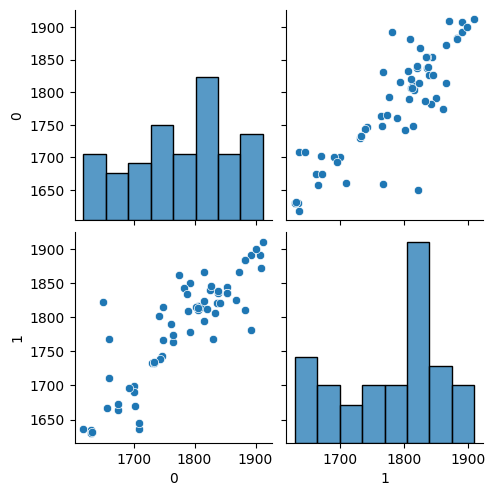

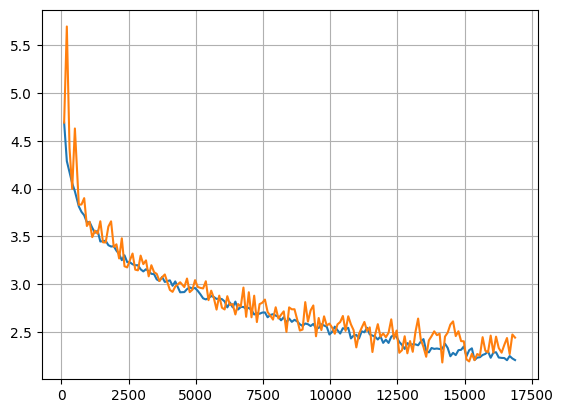

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


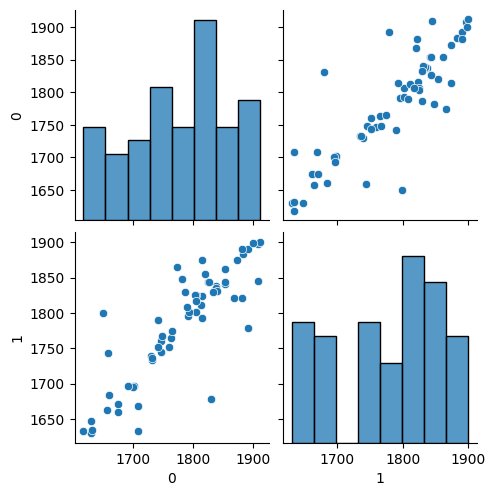

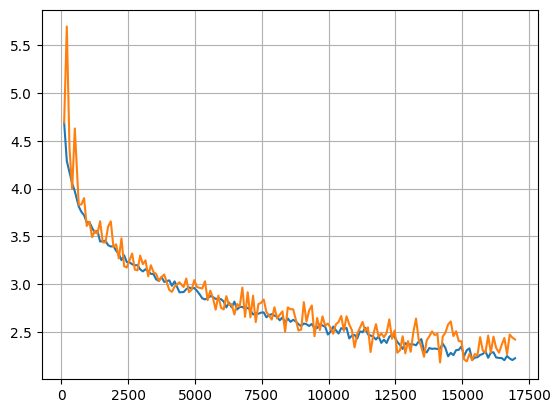

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


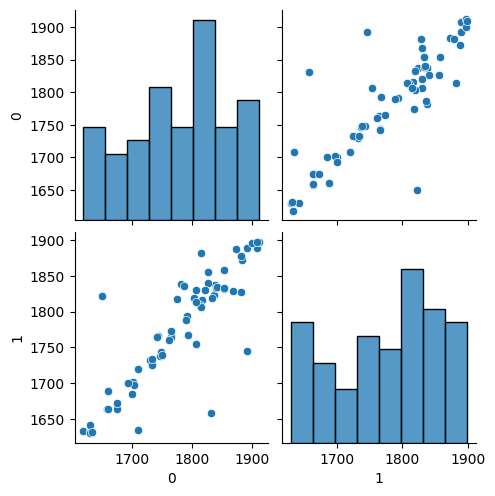

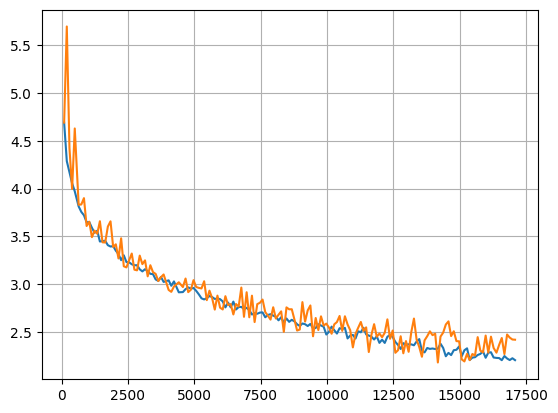

========== EPOCH 17 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


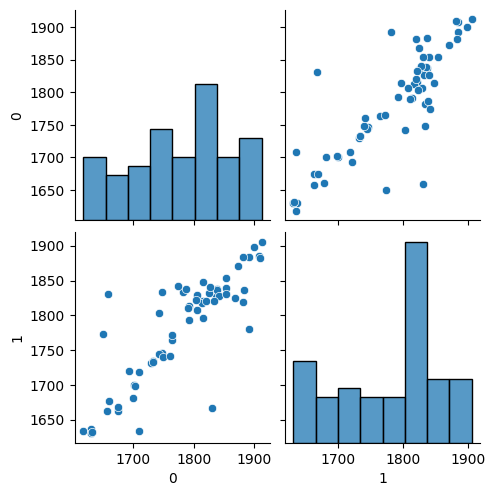

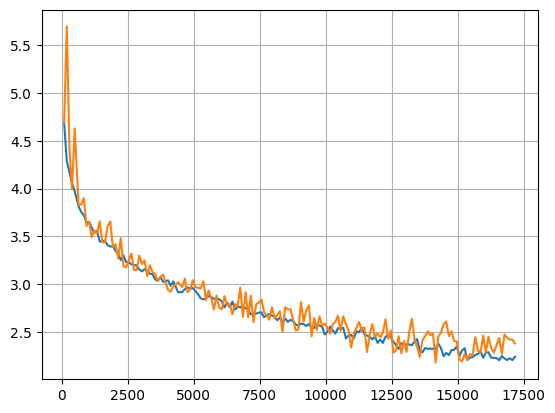

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


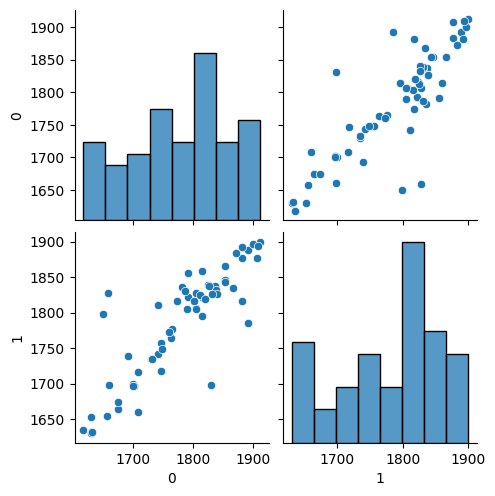

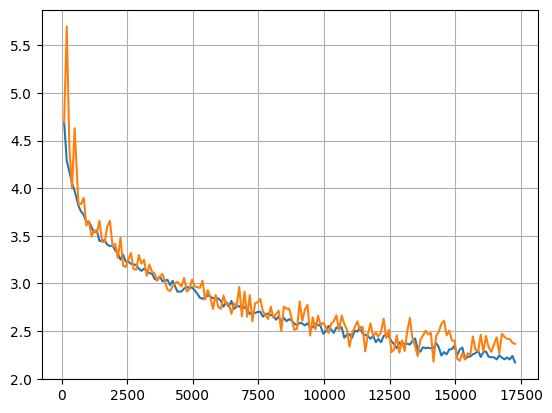

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


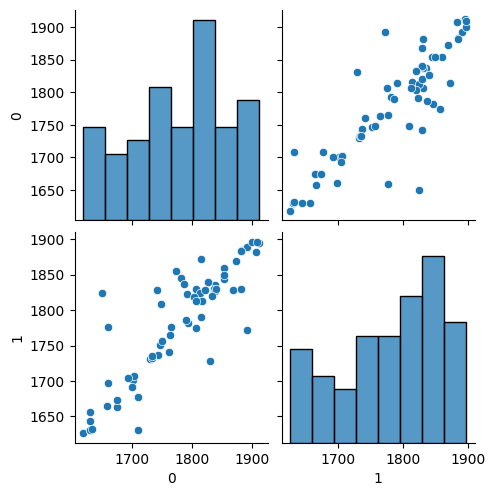

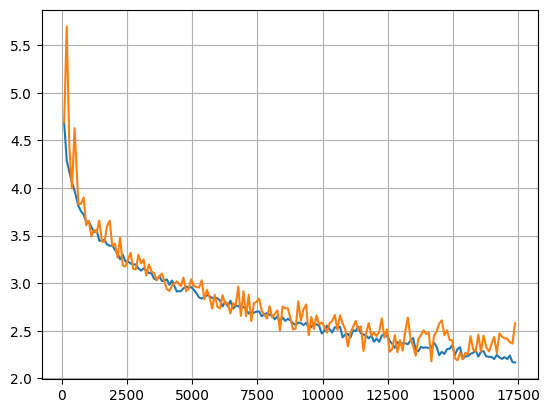

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


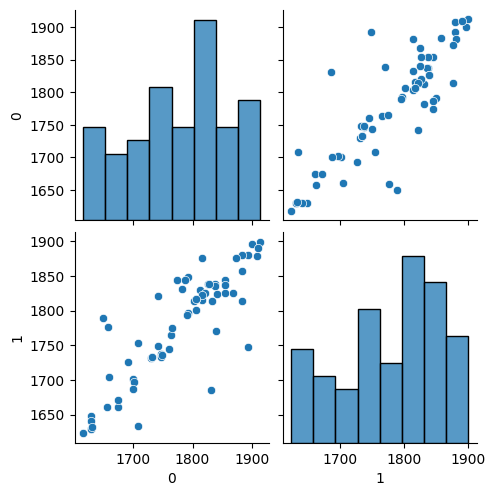

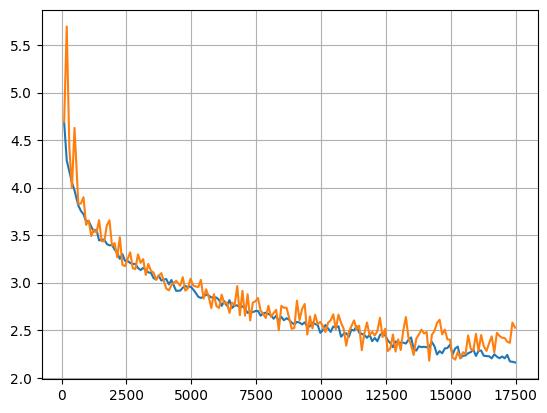

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


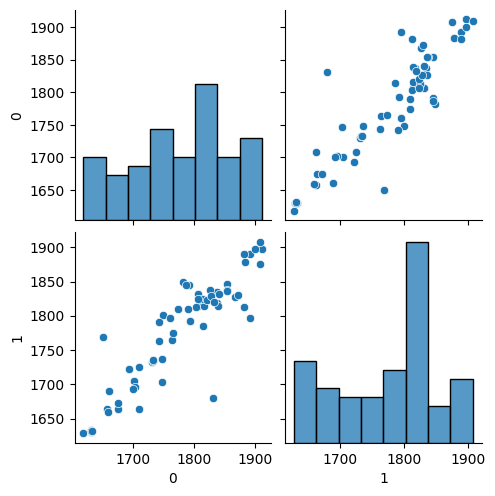

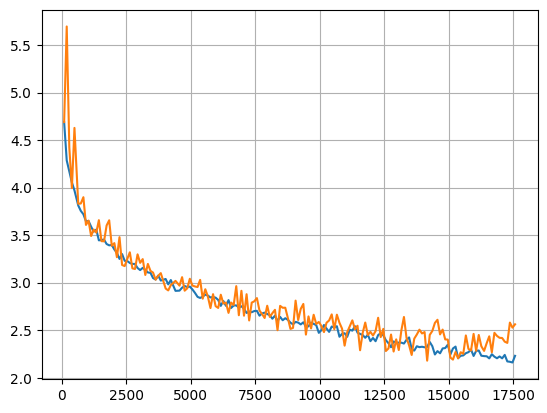

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


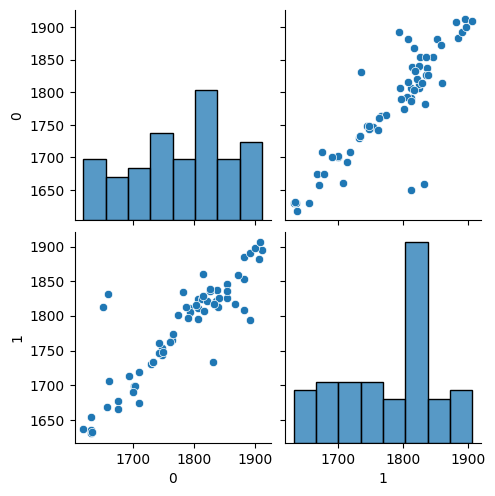

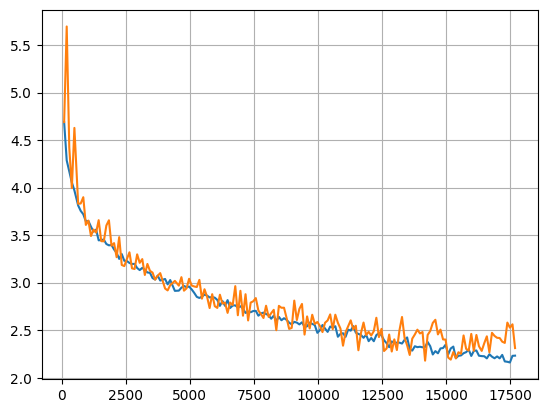

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


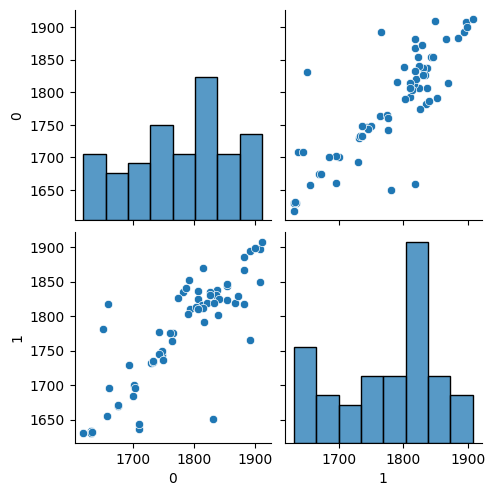

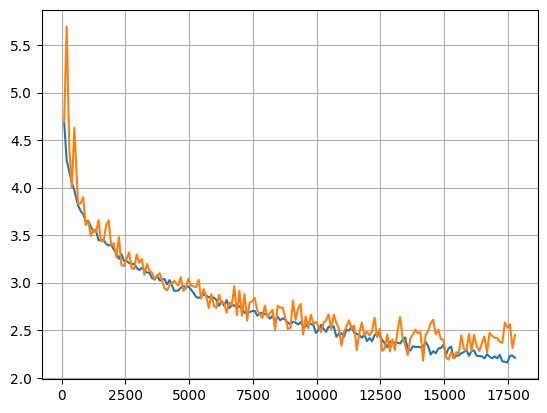

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


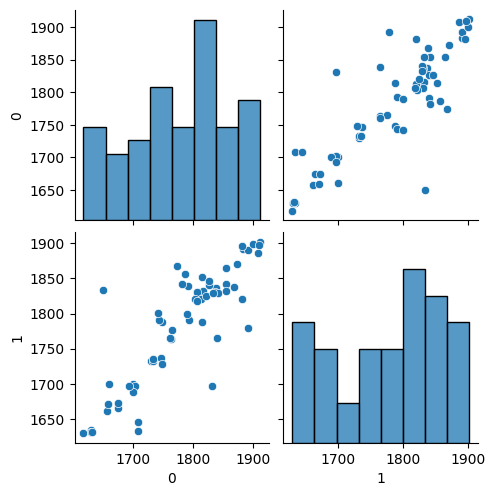

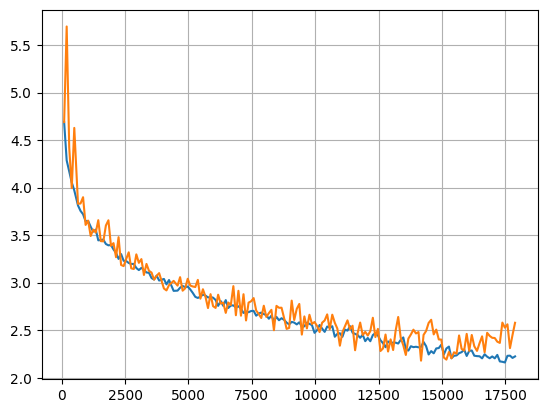

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


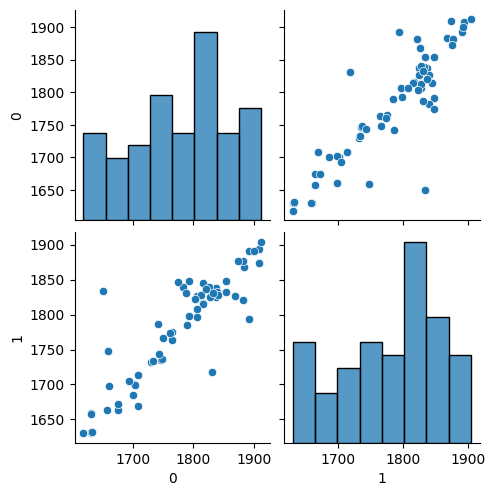

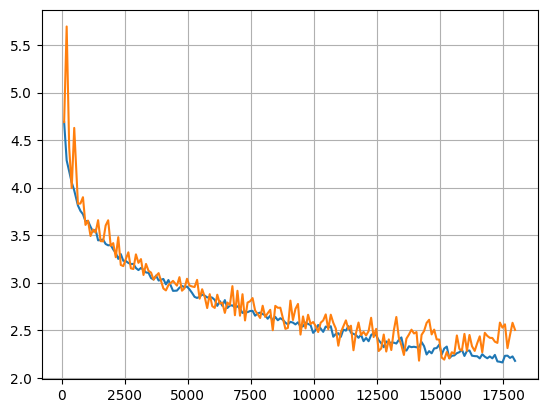

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


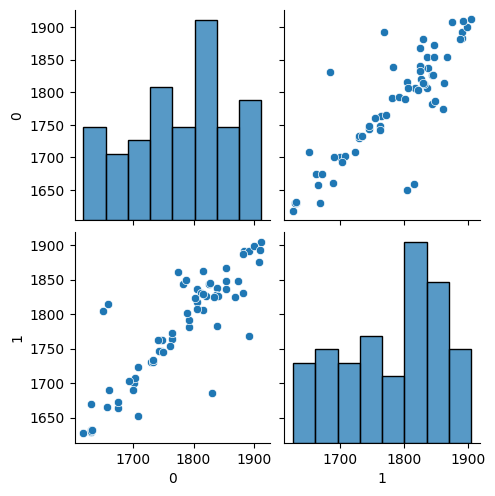

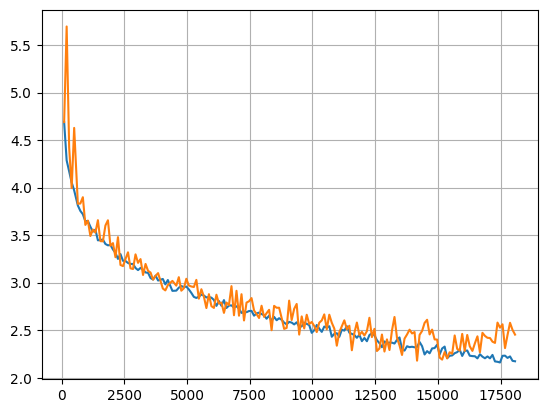

========== EPOCH 18 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


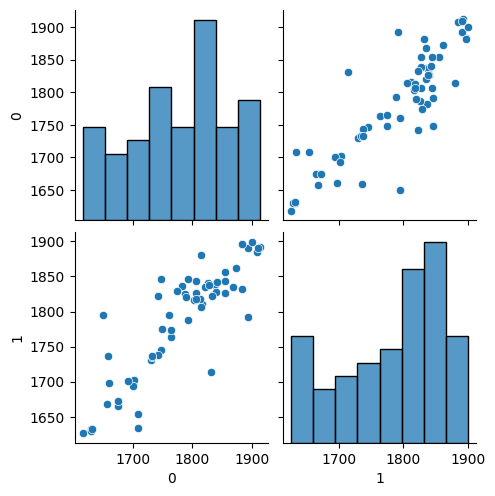

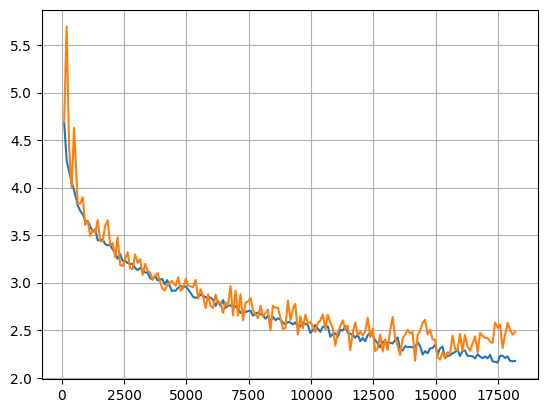

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


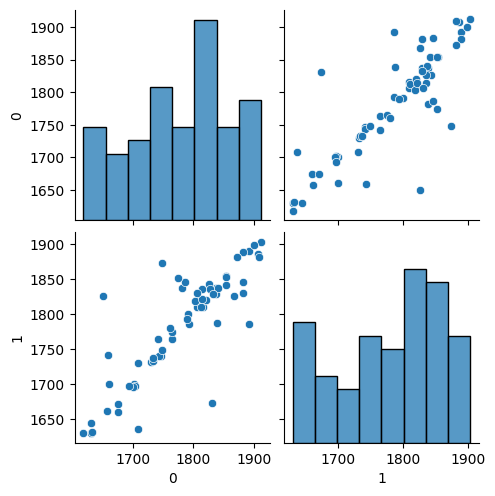

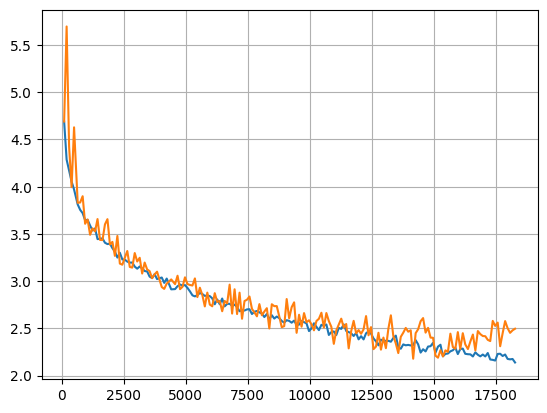

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


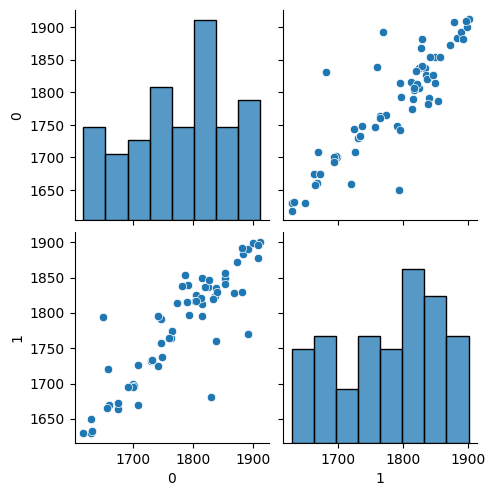

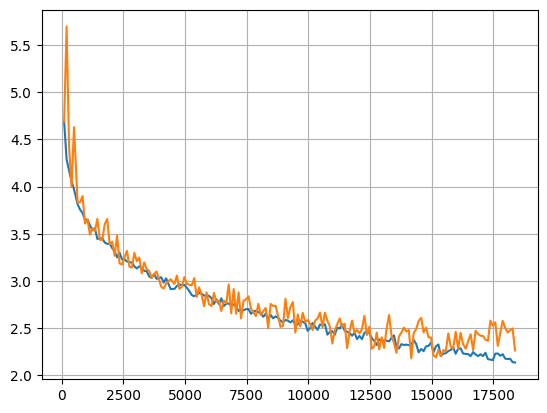

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


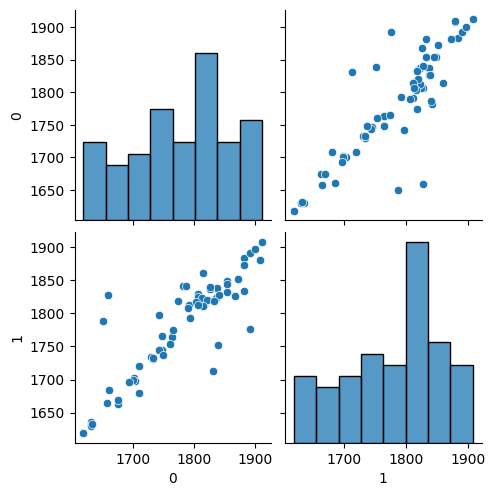

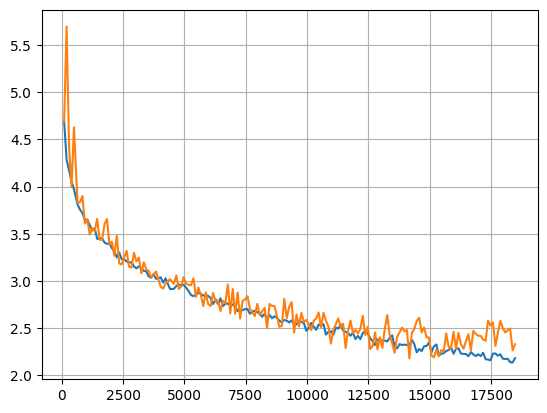

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


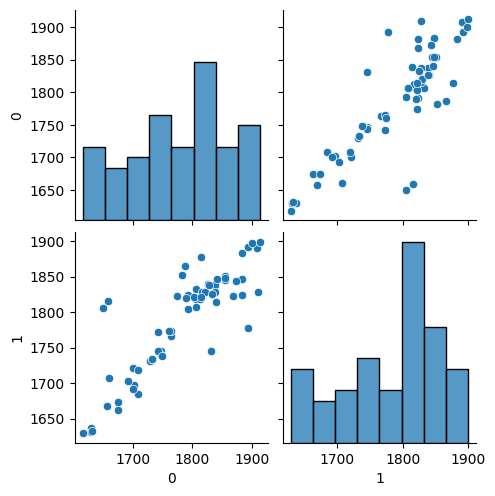

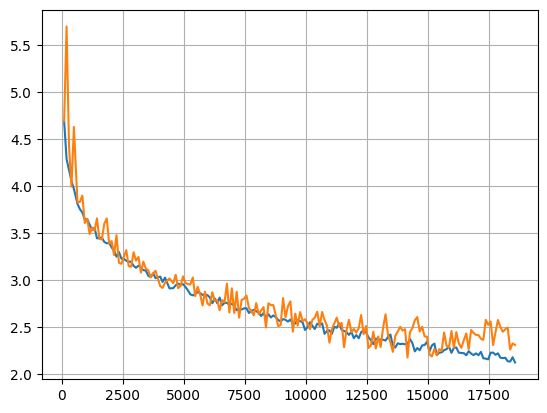

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


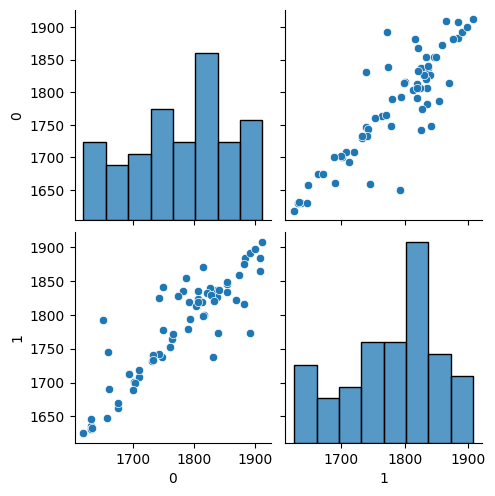

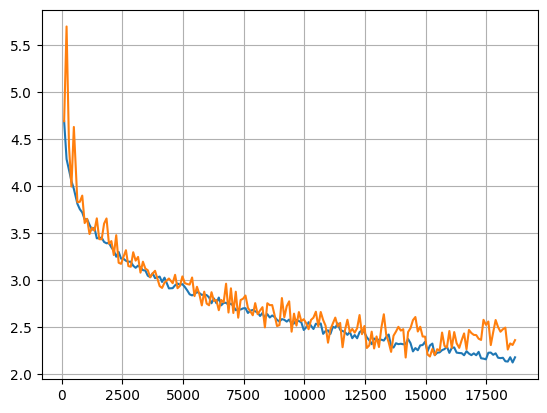

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


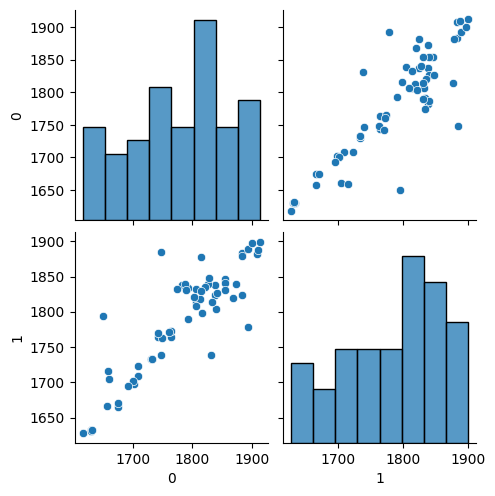

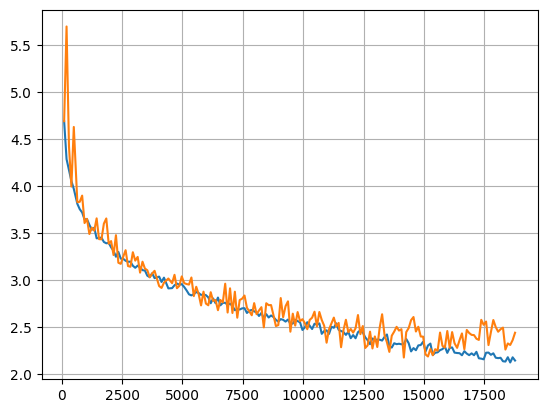

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


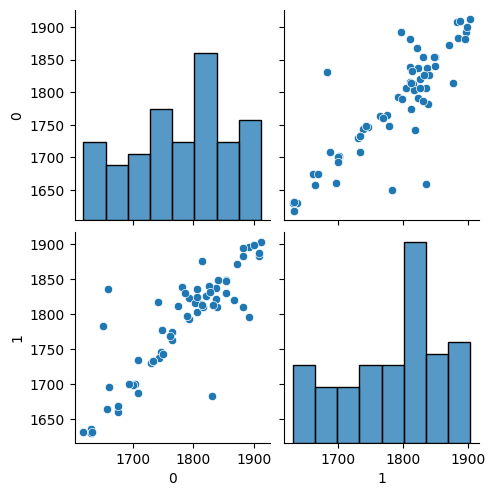

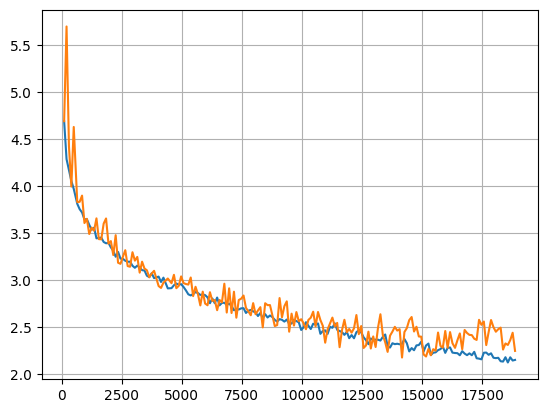

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


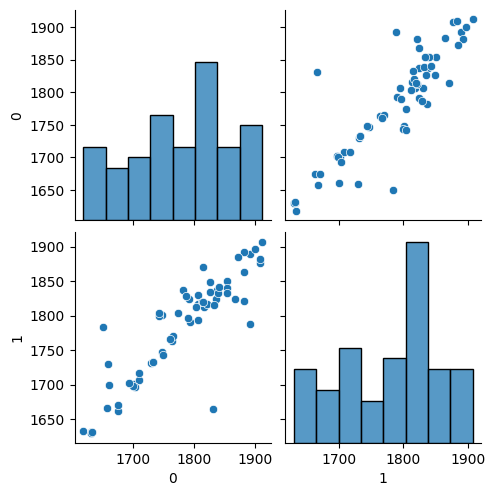

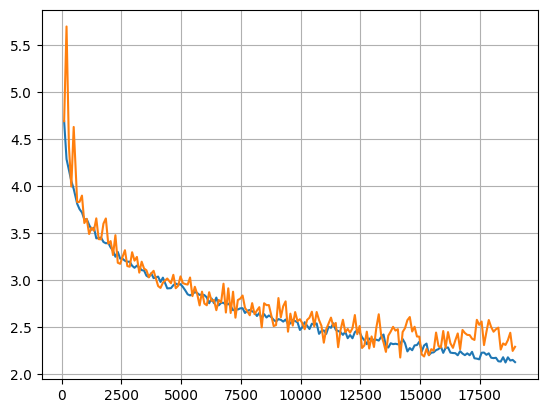

========== EPOCH 19 COMPLETED ==========


D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


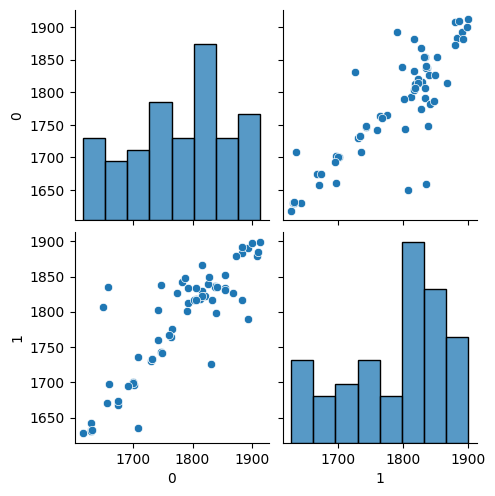

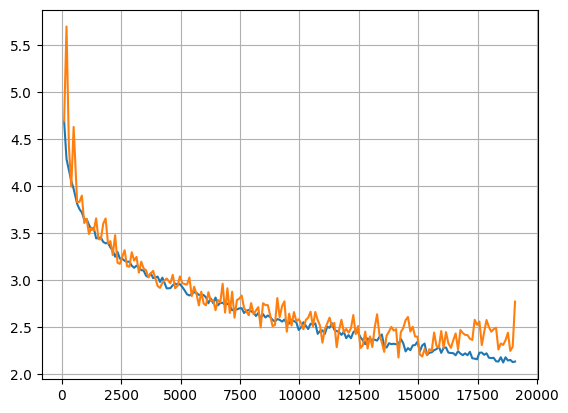

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


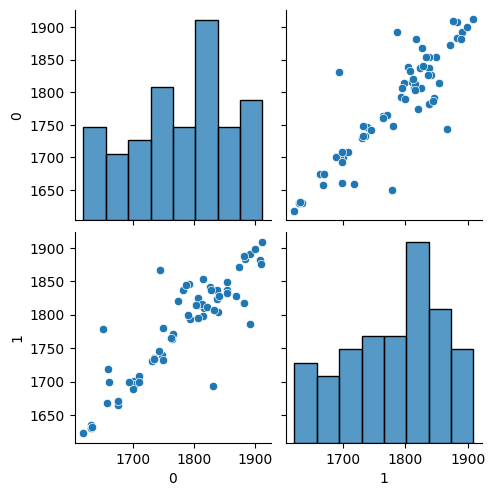

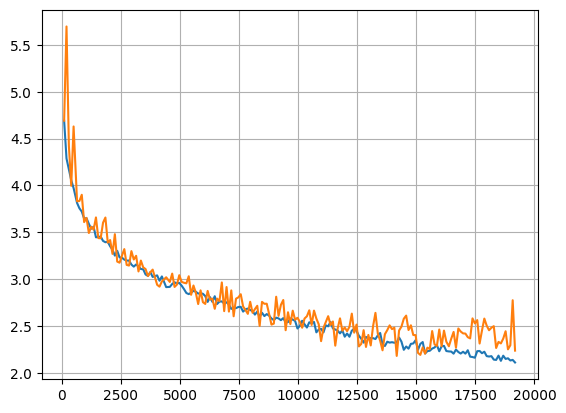

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


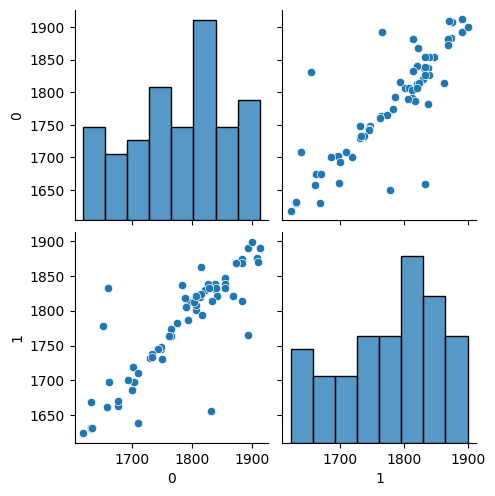

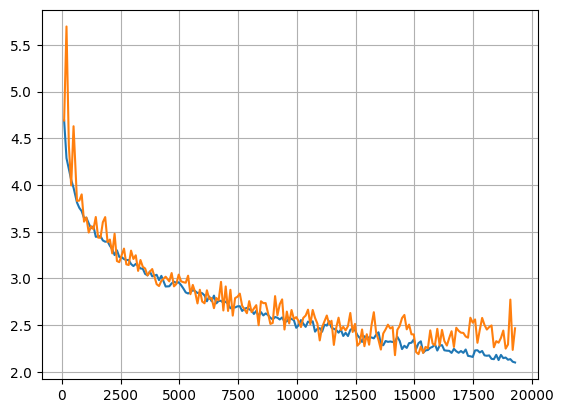

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


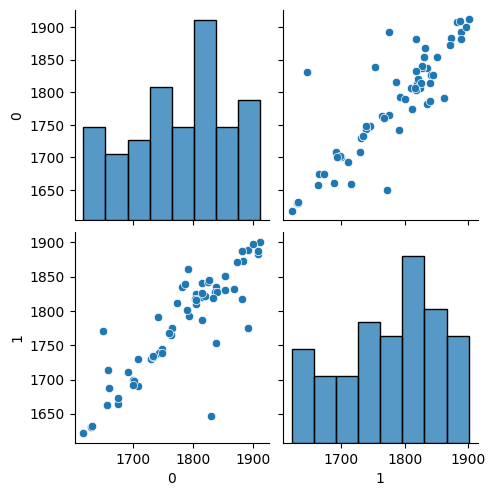

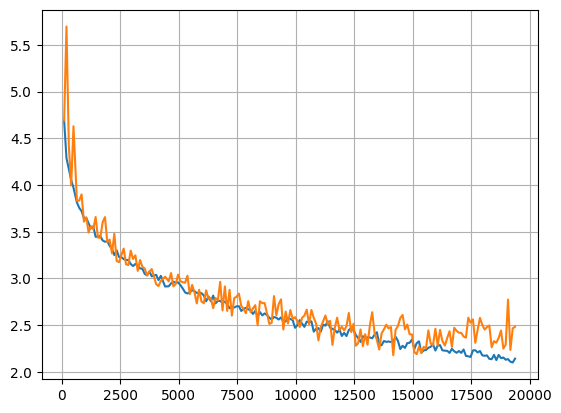

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


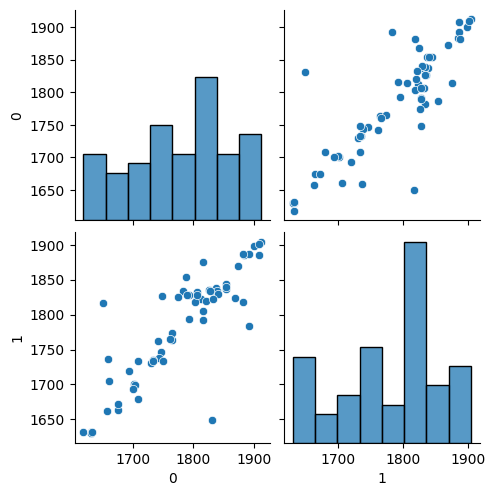

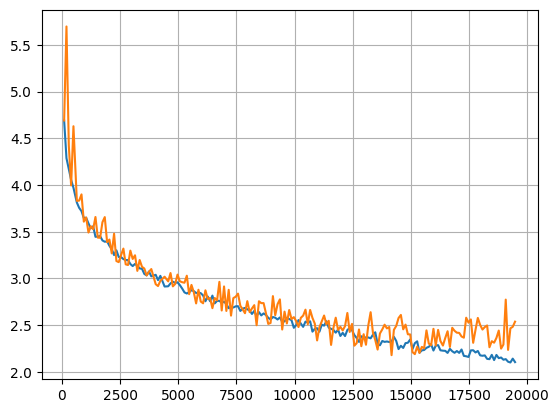

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


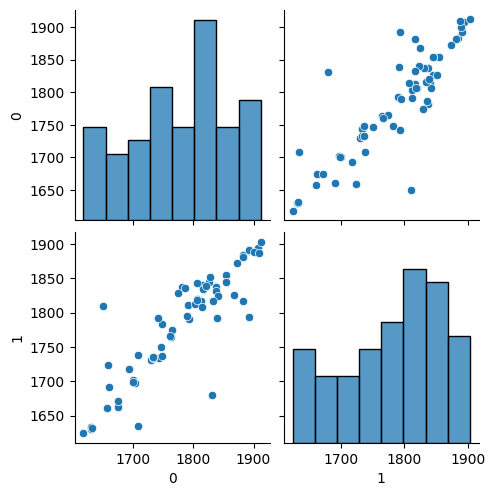

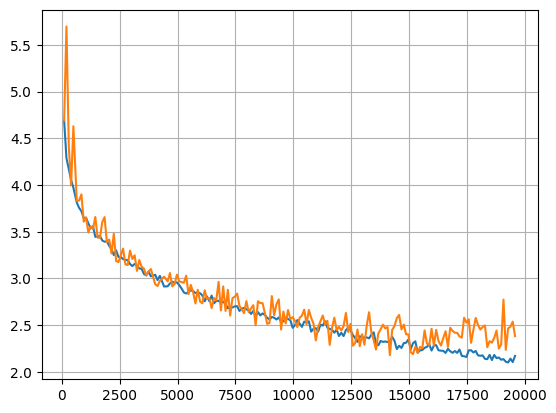

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


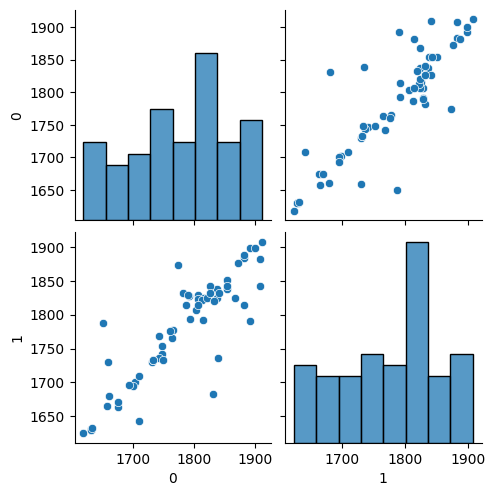

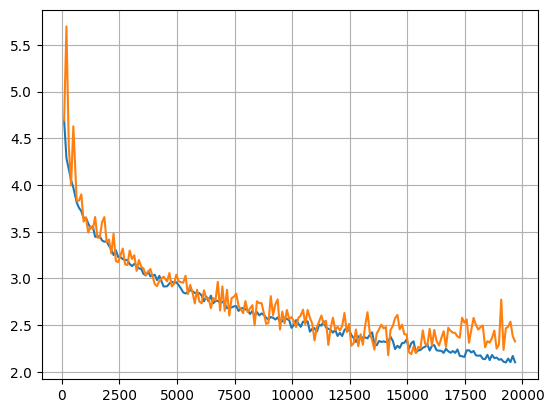

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


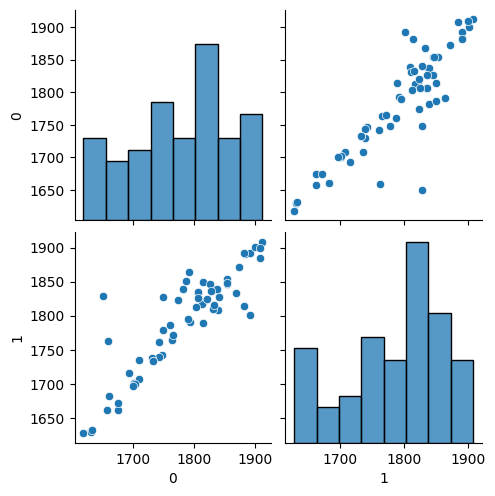

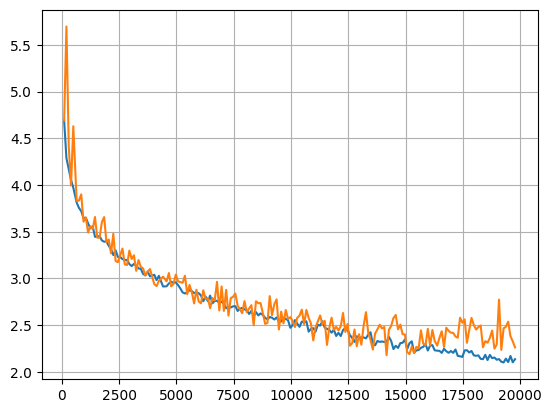

D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


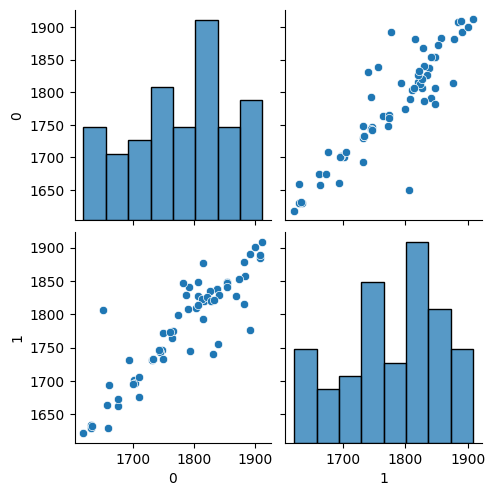

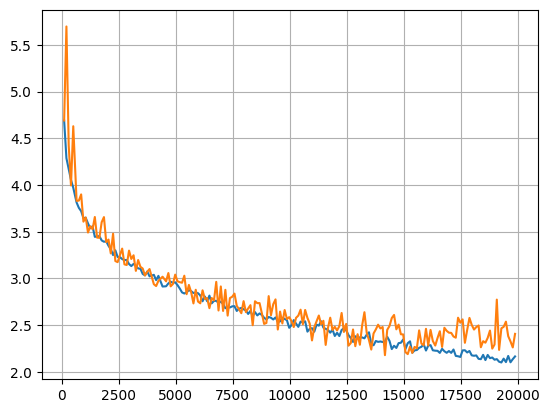

========== EPOCH 20 COMPLETED ==========


KeyboardInterrupt: 

In [79]:
losses = []
vlosses = []
vmin = 9999

for k in trange(999999):
    loss = Loss()
    loss.backward()
    losses.append(loss.item())
    net.optim.step()
    net.optim.zero_grad()
    
    if len(losses) == 100:
        vloss = valloss(plot=True).item()
        if vloss < vmin:
            vmin = vloss
            torch.save(net.state_dict(), 'dlk_weights_061223.dat')
        net.losses.append((net.iters, np.mean(losses)))
        net.vlosses.append((net.iters, vloss))
        losses = []
    net.iters += 1
    
    if k % 100 == 0:
        plt.plot(*zip(*net.losses))
        plt.plot(*zip(*net.vlosses))
        #plt.ylim([0,50])
        plt.grid()
        plt.show()


## Zwei Beispielsätze: Ein einfacher und ein schwerer

In [ ]:
net.load_state_dict(torch.load('rd_weights_281123.dat'))

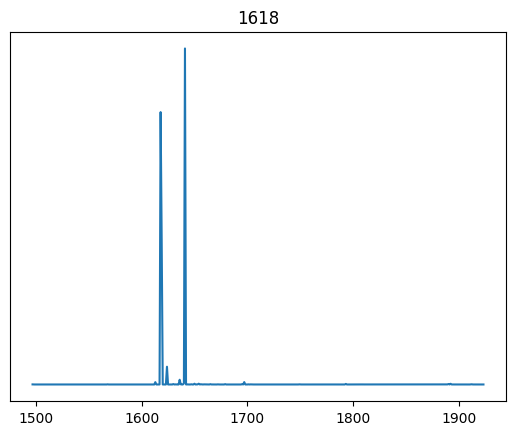

In [80]:
import bpe
net.eval()
i = 100
x = encode(df_val['Encoded'][i], tokenizer.bpe_code)
xs = np2t([x])
with torch.no_grad(): zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(np.arange(YEAR_MIN, YEAR_MAX+1), zp)
plt.title(df_val['Pub year'][i])
plt.gca().axes.get_yaxis().set_ticks([]);

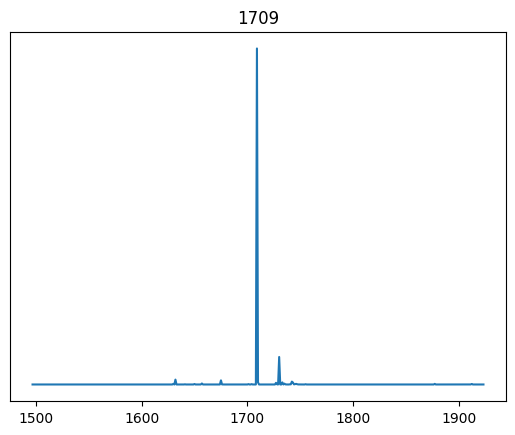

In [81]:
import bpe
net.eval()
i = 1000
x = encode(df_val['Encoded'][i], tokenizer.bpe_code)
xs = np2t([x])
with torch.no_grad(): zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(np.arange(YEAR_MIN, YEAR_MAX+1), zp)
plt.title(df_val['Pub year'][i])
plt.gca().axes.get_yaxis().set_ticks([]);

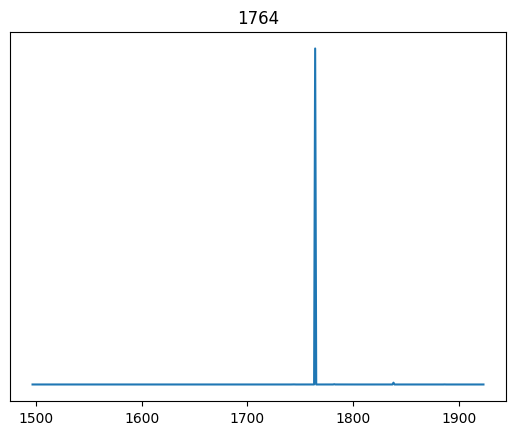

In [82]:
import bpe
net.eval()
i = 500
x = encode(df_val['Encoded'][i], tokenizer.bpe_code)
xs = np2t([x])
with torch.no_grad(): zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(np.arange(YEAR_MIN, YEAR_MAX+1), zp)
plt.title(df_val['Pub year'][i])
plt.gca().axes.get_yaxis().set_ticks([]);

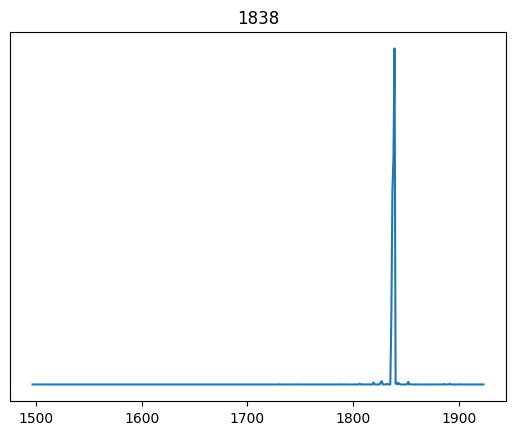

In [83]:
import bpe
net.eval()
i = 300
x = encode(df_val['Encoded'][i], tokenizer.bpe_code)
xs = np2t([x])
with torch.no_grad(): zp = net(xs.long())
zp = F.softmax(zp, dim=1)
zp = t2np(zp)[0]
plt.plot(np.arange(YEAR_MIN, YEAR_MAX+1), zp)
plt.title(df_val['Pub year'][i])
plt.gca().axes.get_yaxis().set_ticks([]);

## Korrelation anzeigen und Ausgleichsgerade

In [84]:
net.eval()
bsize = 50
inds = range(len(df_val))
minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
zps, zss = [], []
for mb in tqdm(minibatches):
    xs, zs, zs2 = [], [], []
    for i in mb:
        x = df_val['Encoded'][i]
        z = df_val['Pub year'][i]
        x = encode(x)
        z = z - YEAR_MIN
        xs.append(x)
        zs.append(z)
        zs2.append(z)
    xs, zs = np2t(xs, zs)
    zp = net(xs.long())
    zp = F.softmax(zp, dim=1)
    zp, zs = t2np(zp, zs)
    zp = np.sum(zp * np.arange(NBINS), -1)
    zps.append(zp)
    zss.append(zs2)

zp = np.concatenate(zps)
zs = np.concatenate(zss)

  0%|          | 0/131 [00:00<?, ?it/s]

In [49]:
zs

array([250, 250, 250, ..., 276, 276, 276], dtype=int64)

Text(0, 0.5, 'Predicted Year')

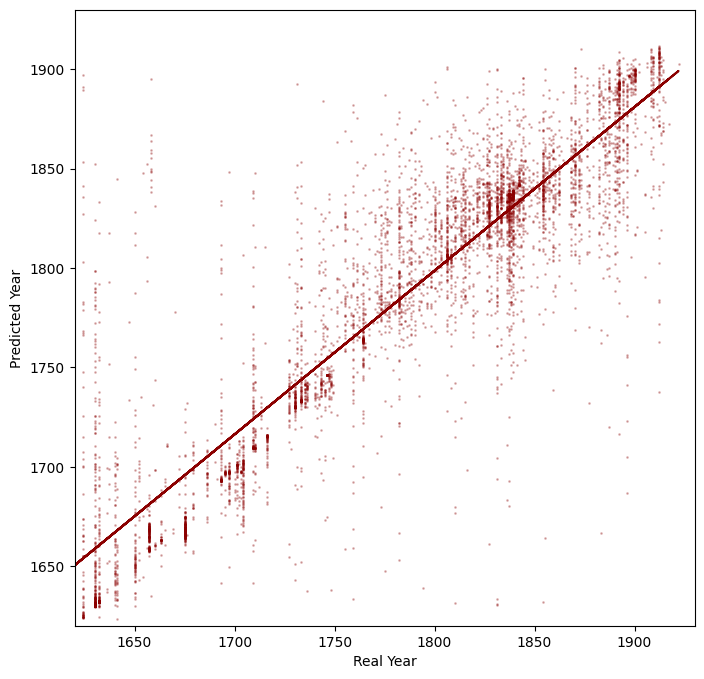

In [91]:
import numpy as np
import matplotlib.pyplot as plt

xs = zs + YEAR_MIN
ys = zp + YEAR_MIN

# Lineare Regression
slope, intercept = np.polyfit(xs, ys, 1)

# Erstellen der Ausgleichsgeraden
fit_line = np.polyval([slope, intercept], xs)

# Plot der Datenpunkte und der Ausgleichsgeraden
plt.figure(figsize=(8, 8))
plt.scatter(xs, ys, s=1, alpha=0.25, color='darkred', label='Datenpunkte')
plt.plot(xs, fit_line, '-', color='darkred', label='Ausgleichsgerade')
#plt.legend()
#plt.axis('equal')
#plt.axis('off')
plt.xlim([1620, 1930])
plt.ylim([1620, 1930])
plt.xlabel('Real Year')
plt.ylabel('Predicted Year')